
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [4]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

X = ha.drop(["cp"], axis=1)
y = ha['cp']
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]
).set_output(transform="pandas")

knn_pipeline.fit(X, y)

scores = abs(cross_val_score(knn_pipeline, X, y, cv=5, scoring='roc_auc_ovr'))
print(scores.mean())


0.5962262199130134


0.502481952006453


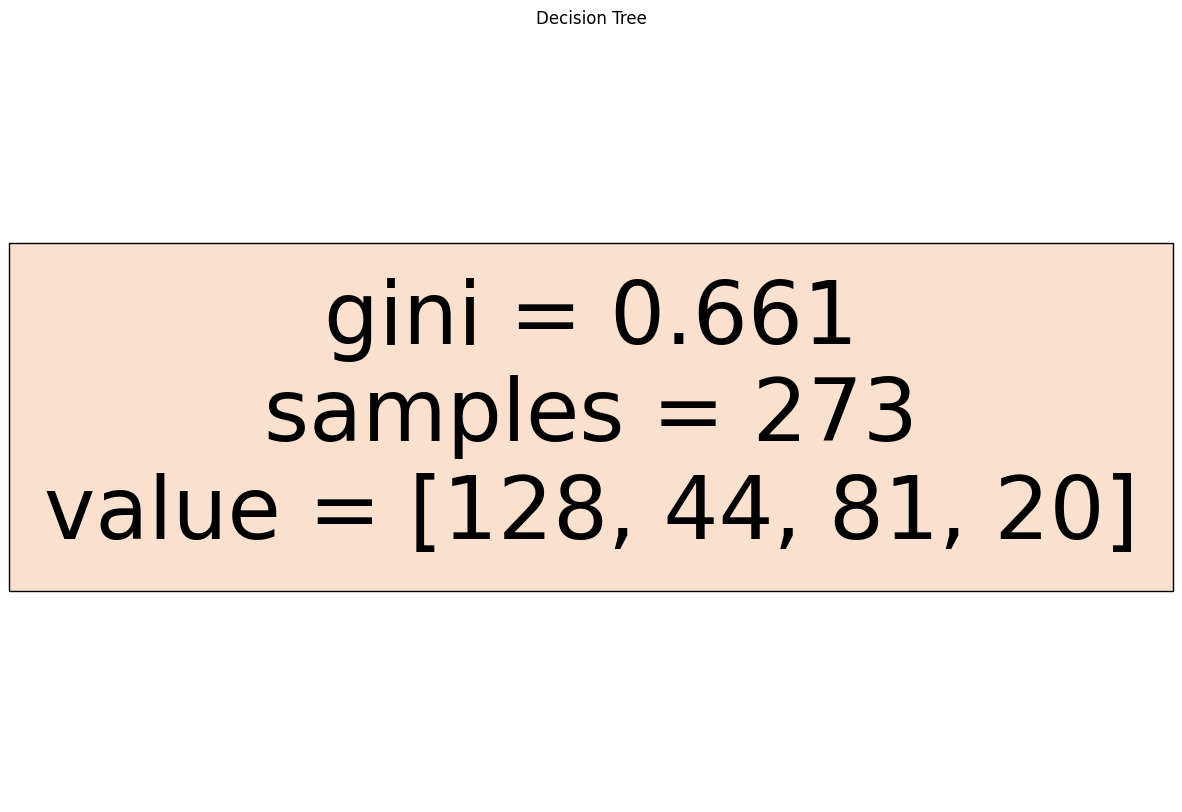

Best ccp_alpha: 0.01
Best cross-validated score: 0.48377104377104374


In [10]:
X = ha.drop(["cp"], axis=1)
y = ha['cp']

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.1))]
).set_output(transform="pandas")

dt_pipeline.fit(X, y)

scores = abs(cross_val_score(dt_pipeline, X, y, cv=5, scoring='roc_auc_ovr'))
print(scores.mean())

decision_tree = dt_pipeline.named_steps ['dt']
plt.figure(figsize=(15, 10))
plot_tree(decision_tree, filled=True, feature_names=ct.get_feature_names_out())
plt.title("Decision Tree")
plt.show()

ccp_alphas = {'dt__ccp_alpha': [0.001,0.01,0.1,1,10]}

gscv = GridSearchCV(dt_pipeline, ccp_alphas, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_


best_alpha = gscv_fitted.best_params_['dt__ccp_alpha']
best_model = gscv_fitted.best_estimator_

print(f"Best ccp_alpha: {best_alpha}")
print(f"Best cross-validated score: {gscv_fitted.best_score_}")

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [11]:
new_ha = ha.copy()
new_ha['cp_is_0'] = np.where(new_ha['cp'] == 0, 1, 0)
new_ha['cp_is_1'] = np.where(new_ha['cp'] == 1, 1, 0)
new_ha['cp_is_2'] = np.where(new_ha['cp'] == 2, 1, 0)
new_ha['cp_is_3'] = np.where(new_ha['cp'] == 3, 1, 0)



X = new_ha.drop(["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3"], axis=1)
y = new_ha['cp_is_0']

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='f1'))
print(scores.mean())

0.6525962644949986


In [14]:
#1
X = new_ha.drop(["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3"], axis=1)
y = new_ha['cp_is_1']

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline.fit(X, y)

scores1 = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='f1'))
print(scores1.mean())

#2
X = new_ha.drop(["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3"], axis=1)
y = new_ha['cp_is_2']

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline.fit(X, y)

scores2 = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='f1'))
print(scores2.mean())

#3
X = new_ha.drop(["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3"], axis=1)
y = new_ha['cp_is_3']

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline.fit(X, y)

scores3 = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='f1'))
print(scores3.mean())

0.0
0.1393939393939394
0.0


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [15]:
ha_0_1 = ha[(new_ha['cp'] == 0) | (ha['cp'] == 1)]
ha_0_2 = ha[(new_ha['cp'] == 0) | (ha['cp'] == 2)]
ha_0_3 = ha[(new_ha['cp'] == 0) | (ha['cp'] == 3)]

#1
X = ha_0_1.drop(["cp"], axis=1)
y = ha_0_1['cp']

logistic_pipeline.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc'))
print(scores.mean())

#2
X = ha_0_2.drop(["cp"], axis=1)
y = ha_0_2['cp']

logistic_pipeline.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc'))
print(scores.mean())

#3
X = ha_0_3.drop(["cp"], axis=1)
y = ha_0_3['cp']

logistic_pipeline.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc'))
print(scores.mean())



0.8376709401709401
0.7511029411764706
0.7412307692307692
